In [2]:
import numpy as np 
import h5py
import os
import matplotlib.pyplot as plt

In [3]:
from Utilz.losses import re_im_sep_vectors, re_im_combined

In [5]:
data_dir = "/mnt/oneterra/SFG_reIm_h5/"

file_idx = 91
sample_idx = 15

crystal_length = 100

x2_dataset, y2_dataset = None, None

with h5py.File(os.path.join(data_dir, "X_new_data.h5"), "r") as file:
    x_dataset = file[f"dataset_{file_idx}"]
    # x2_dataset = x_dataset[:]
    data = x_dataset[sample_idx]

with h5py.File(os.path.join(data_dir, "y_new_data.h5"), "r") as file:
    y_dataset = file[f"dataset_{file_idx}"]
    # y2_dataset = y_dataset[:]
    y_dataset = y_dataset[crystal_length - 1 :][::crystal_length]
    label = y_dataset[sample_idx]


In [9]:
data.shape

(10, 8264)

In [21]:
x2_dataset.shape

(10000, 10, 8264)

In [22]:
y_dataset.shape

(100, 8264)

In [20]:
y2_dataset.shape

(10000, 8264)

In [11]:
data.shape

(10, 8264)

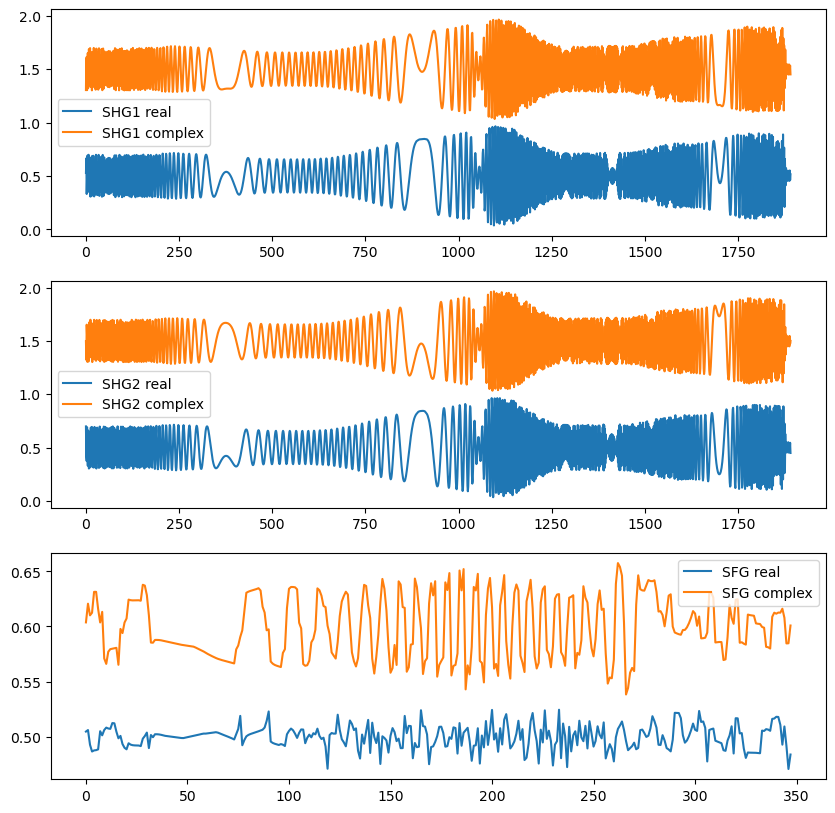

In [10]:
shg1_real, shg1_complex, shg2_real, shg2_complex, sfg_real, sfg_complex = re_im_sep_vectors(data)

# for all of them, get the last index
shg1_real = shg1_real[-1]
shg1_complex = shg1_complex[-1]
shg2_real = shg2_real[-1]
shg2_complex = shg2_complex[-1]
sfg_real = sfg_real[-1]
sfg_complex = sfg_complex[-1]


shg_offset = 1
sfg_offset = 0.1

# plot each signal separately
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(shg1_real, label="SHG1 real")
ax[0].plot(shg1_complex + shg_offset, label="SHG1 complex")
ax[0].legend()

ax[1].plot(shg2_real, label="SHG2 real")
ax[1].plot(shg2_complex + shg_offset, label="SHG2 complex")
ax[1].legend()

ax[2].plot(sfg_real, label="SFG real")
ax[2].plot(sfg_complex + sfg_offset, label="SFG complex")
ax[2].legend()

# plt.show()

plt.savefig("re_im_sep.png")


In [5]:
from Analysis.analyze_reim import do_analysis

/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


direct, and resampled energies:  9.211628908981297e-12 9.211628908981299e-12
direct, and resampled energies:  1.694498414041125e-09 1.694498414041125e-09
direct, and resampled energies:  2.4999996024051802e-05 2.4999996024051802e-05
direct, and resampled energies:  2.4999153783079274e-05 2.4999153783079277e-05
direct, and resampled energies:  2.4999996024051802e-05 2.4999996024051802e-05
direct, and resampled energies:  2.4999153783079277e-05 2.4999153783079274e-05
------- True vs Prediction Frequency Domain --------
*** SFG ***
*** SHG1 ***
*** SHG2 ***
------- True vs Prediction Time Domain --------
*** SFG ***
*** SHG1 ***
*** SHG2 ***


<Figure size 640x480 with 0 Axes>

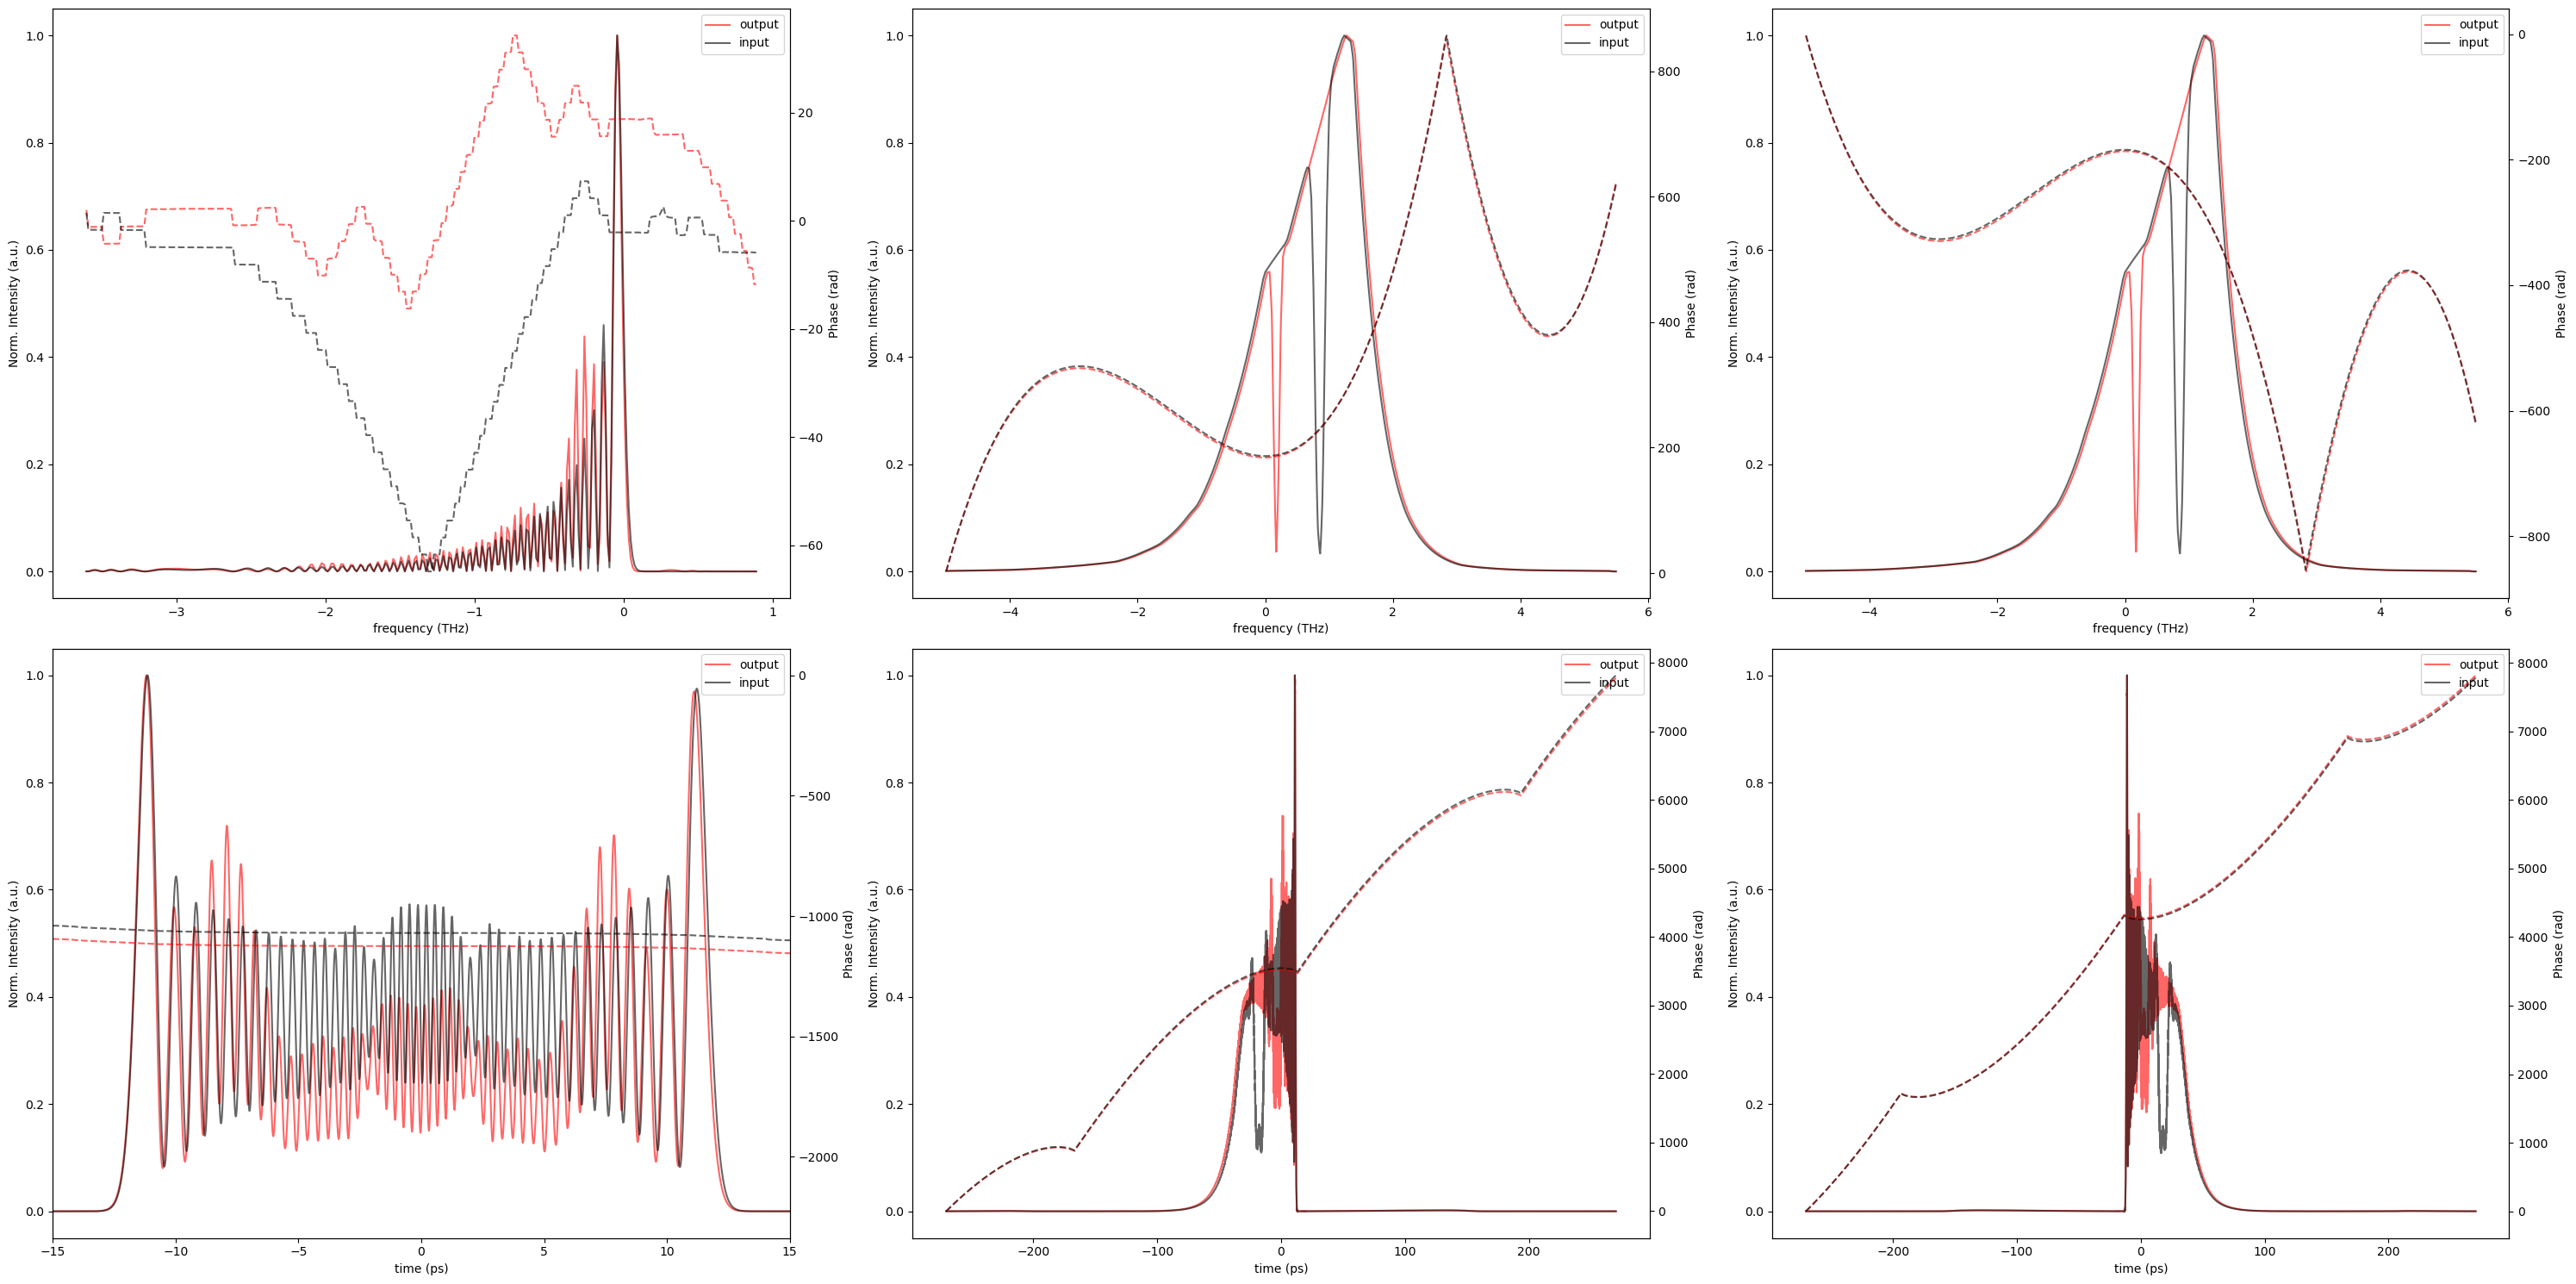

------- True vs Prediction Frequency Domain --------
*** SFG ***
*** SHG1 ***
*** SHG2 ***
------- True vs Prediction Time Domain --------
*** SFG ***
*** SHG1 ***
*** SHG2 ***


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

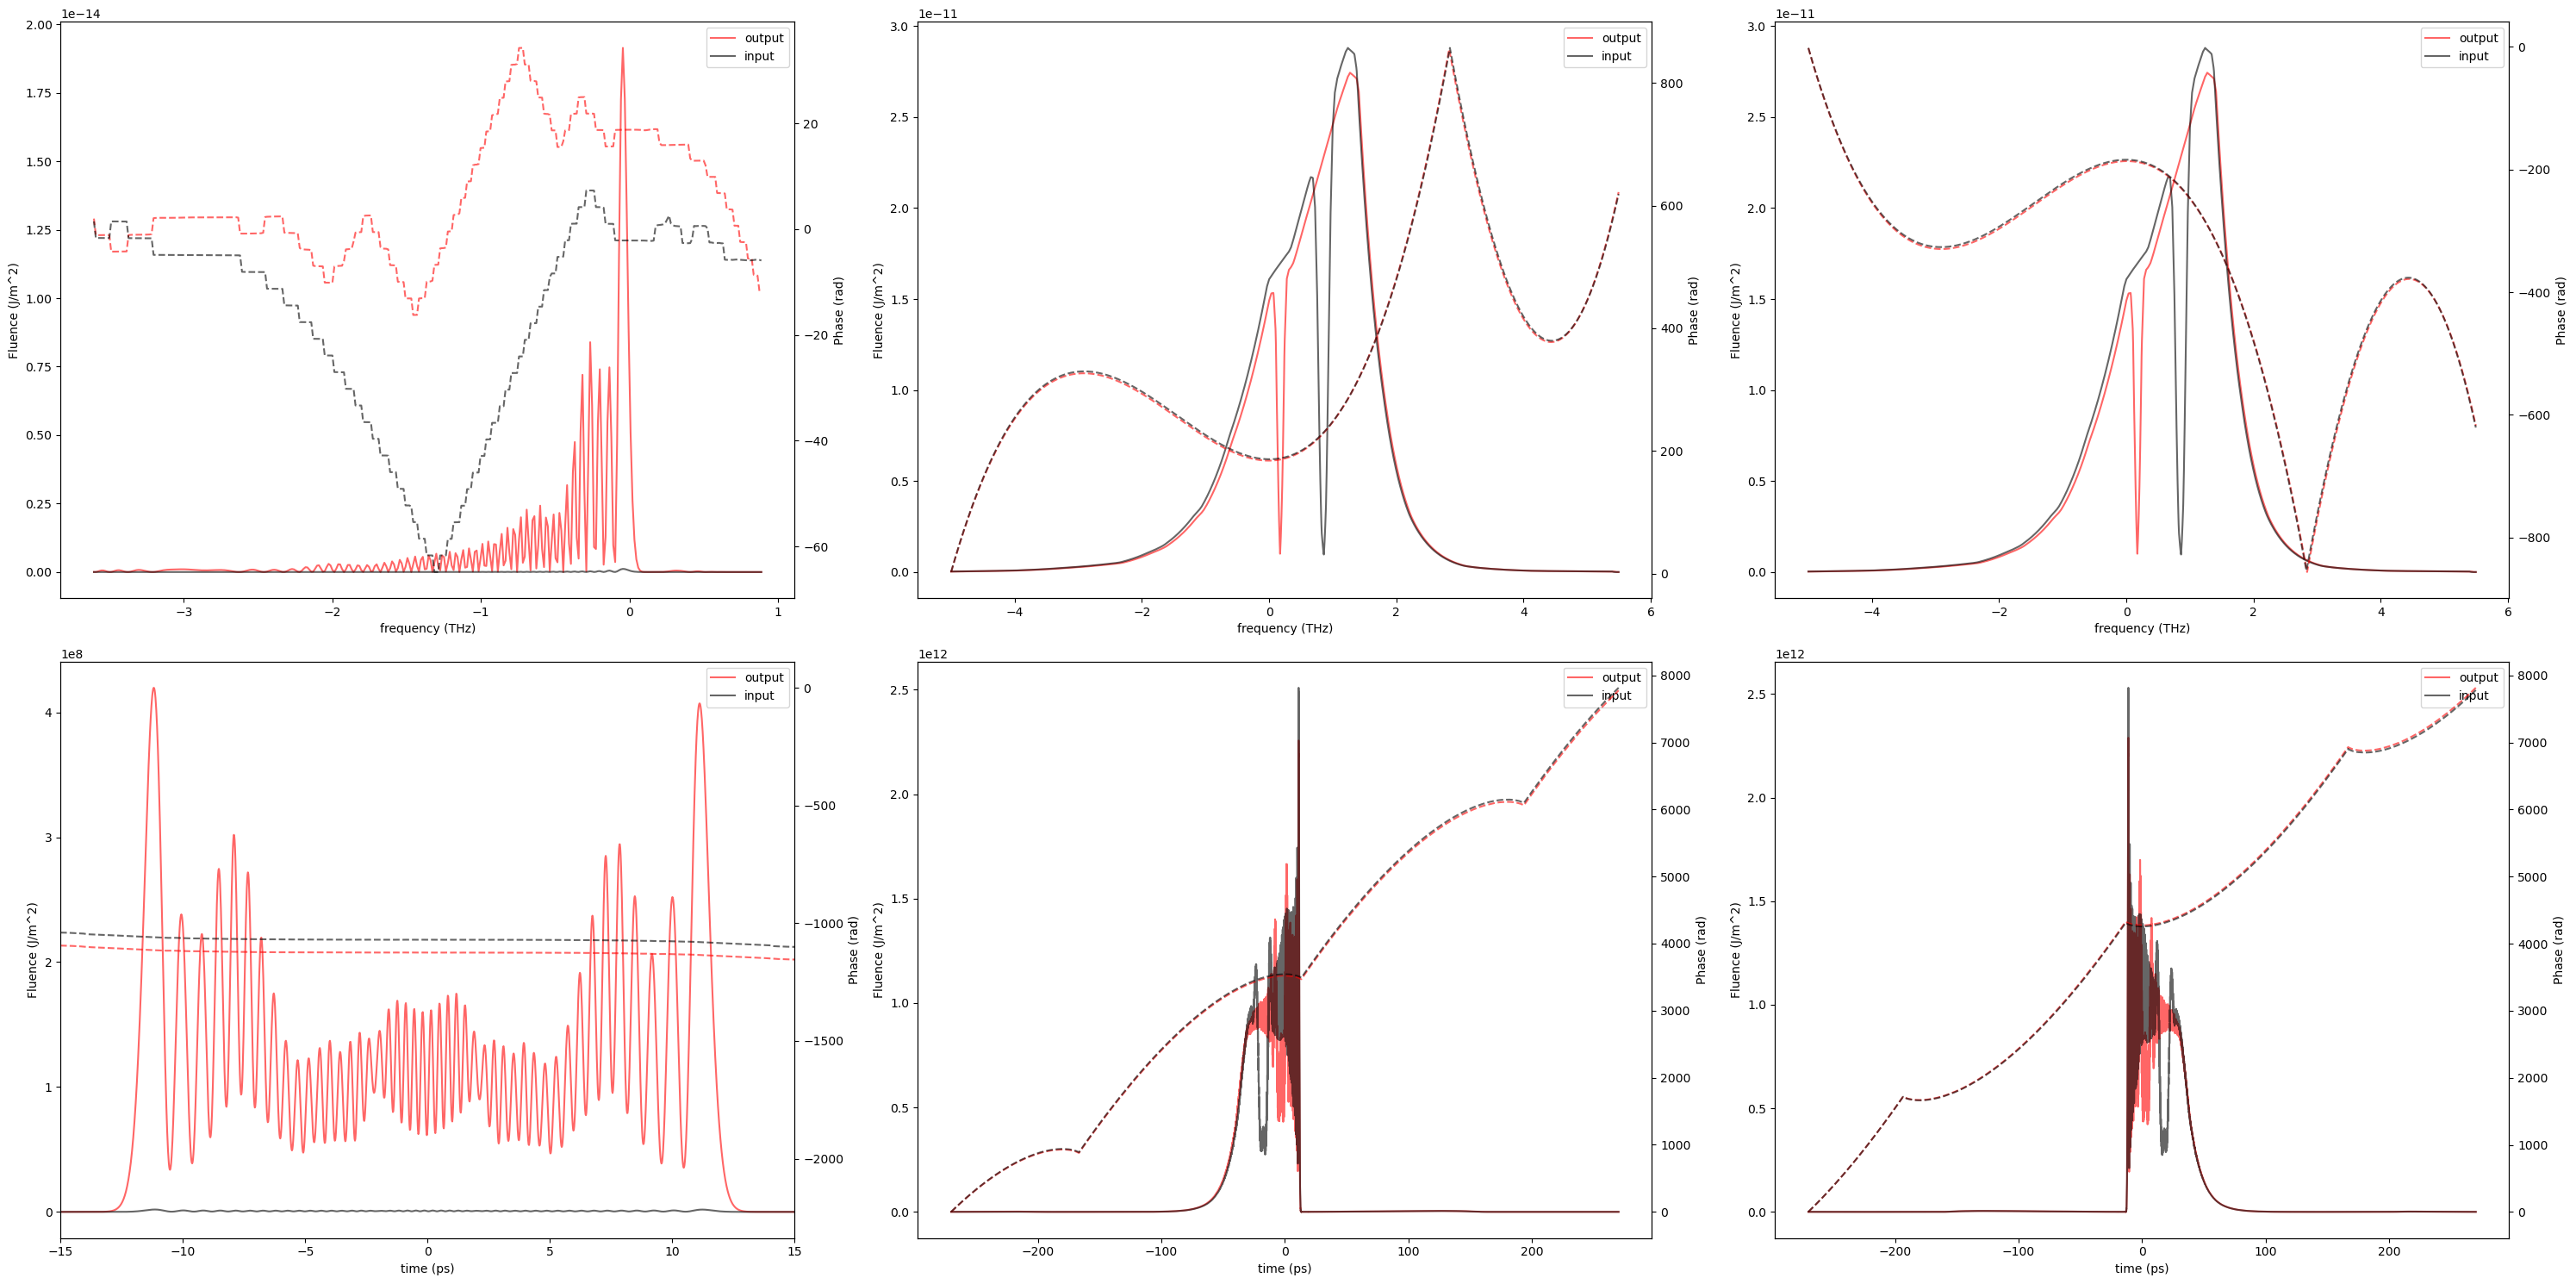

<Figure size 640x480 with 0 Axes>

In [7]:
do_analysis(".", data_dir, "blah", file_idx, sample_idx, ".", crystal_length, y_pred_trans_item=data[0], labels_list=["output", "input"])

/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


direct, and resampled energies:  1.694498414041125e-09 1.694498414041125e-09
direct, and resampled energies:  1.694498414041125e-09 1.694498414041125e-09
direct, and resampled energies:  2.4999153783079274e-05 2.4999153783079277e-05
direct, and resampled energies:  2.4999153783079274e-05 2.4999153783079277e-05
direct, and resampled energies:  2.4999153783079277e-05 2.4999153783079274e-05
direct, and resampled energies:  2.4999153783079277e-05 2.4999153783079274e-05
------- True vs Prediction Frequency Domain --------
*** SFG ***
*** SHG1 ***
*** SHG2 ***
------- True vs Prediction Time Domain --------
*** SFG ***
*** SHG1 ***
*** SHG2 ***


<Figure size 640x480 with 0 Axes>

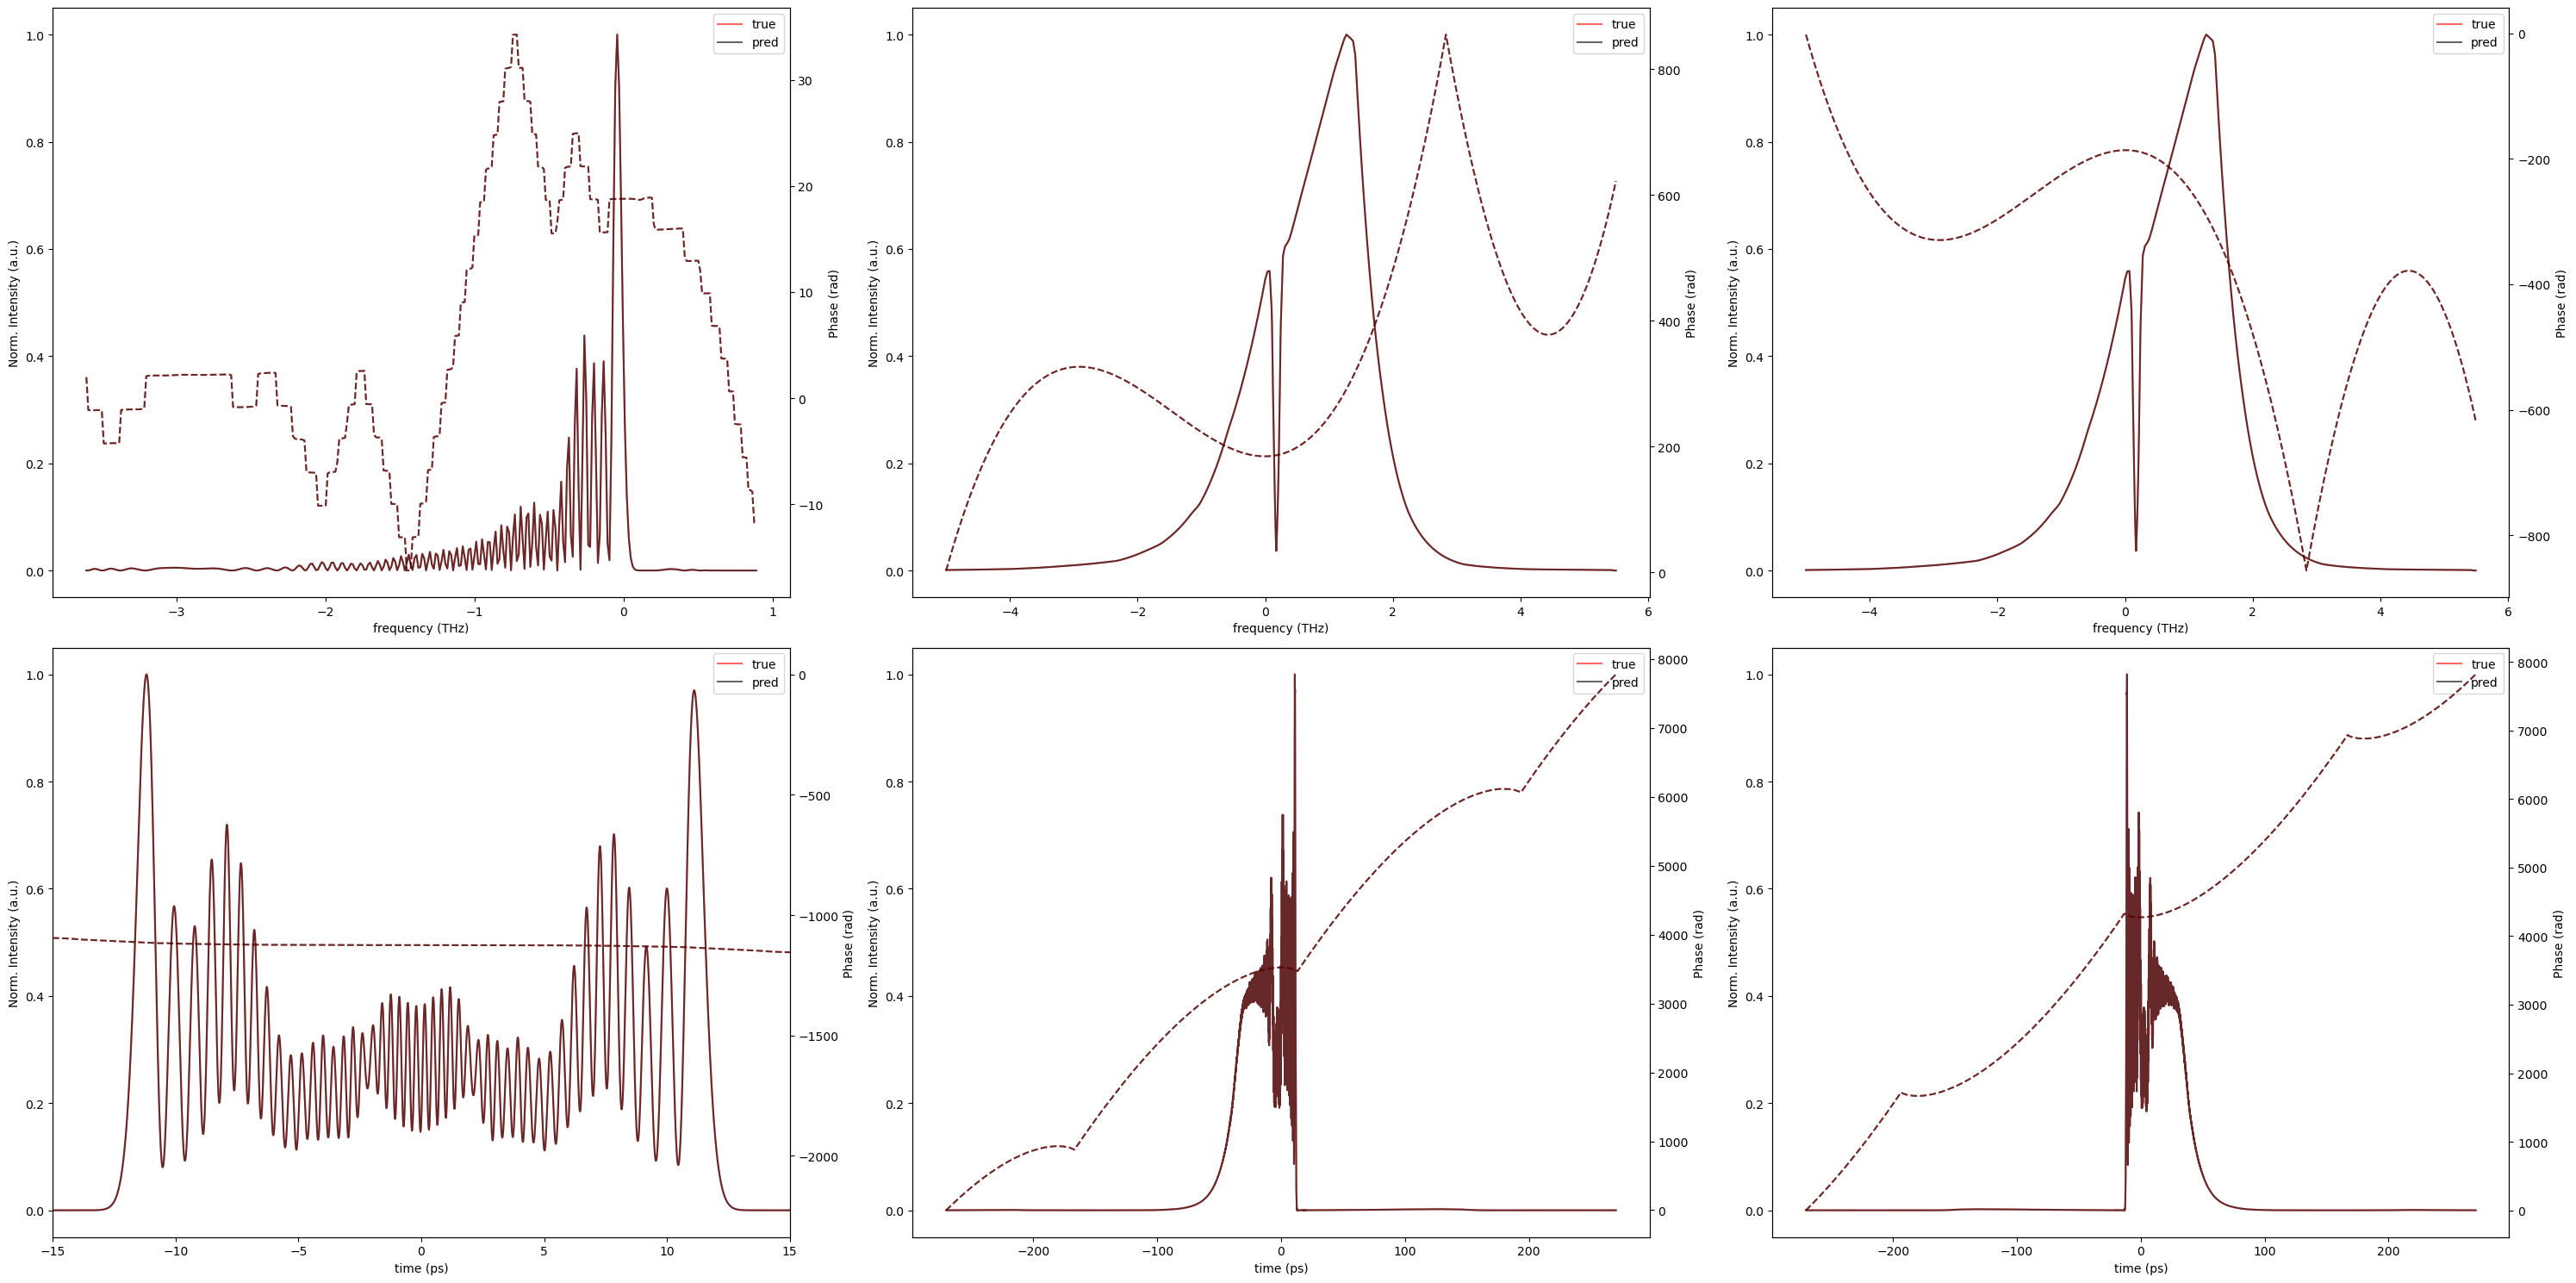

------- True vs Prediction Frequency Domain --------
*** SFG ***
*** SHG1 ***
*** SHG2 ***
------- True vs Prediction Time Domain --------
*** SFG ***
*** SHG1 ***
*** SHG2 ***


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

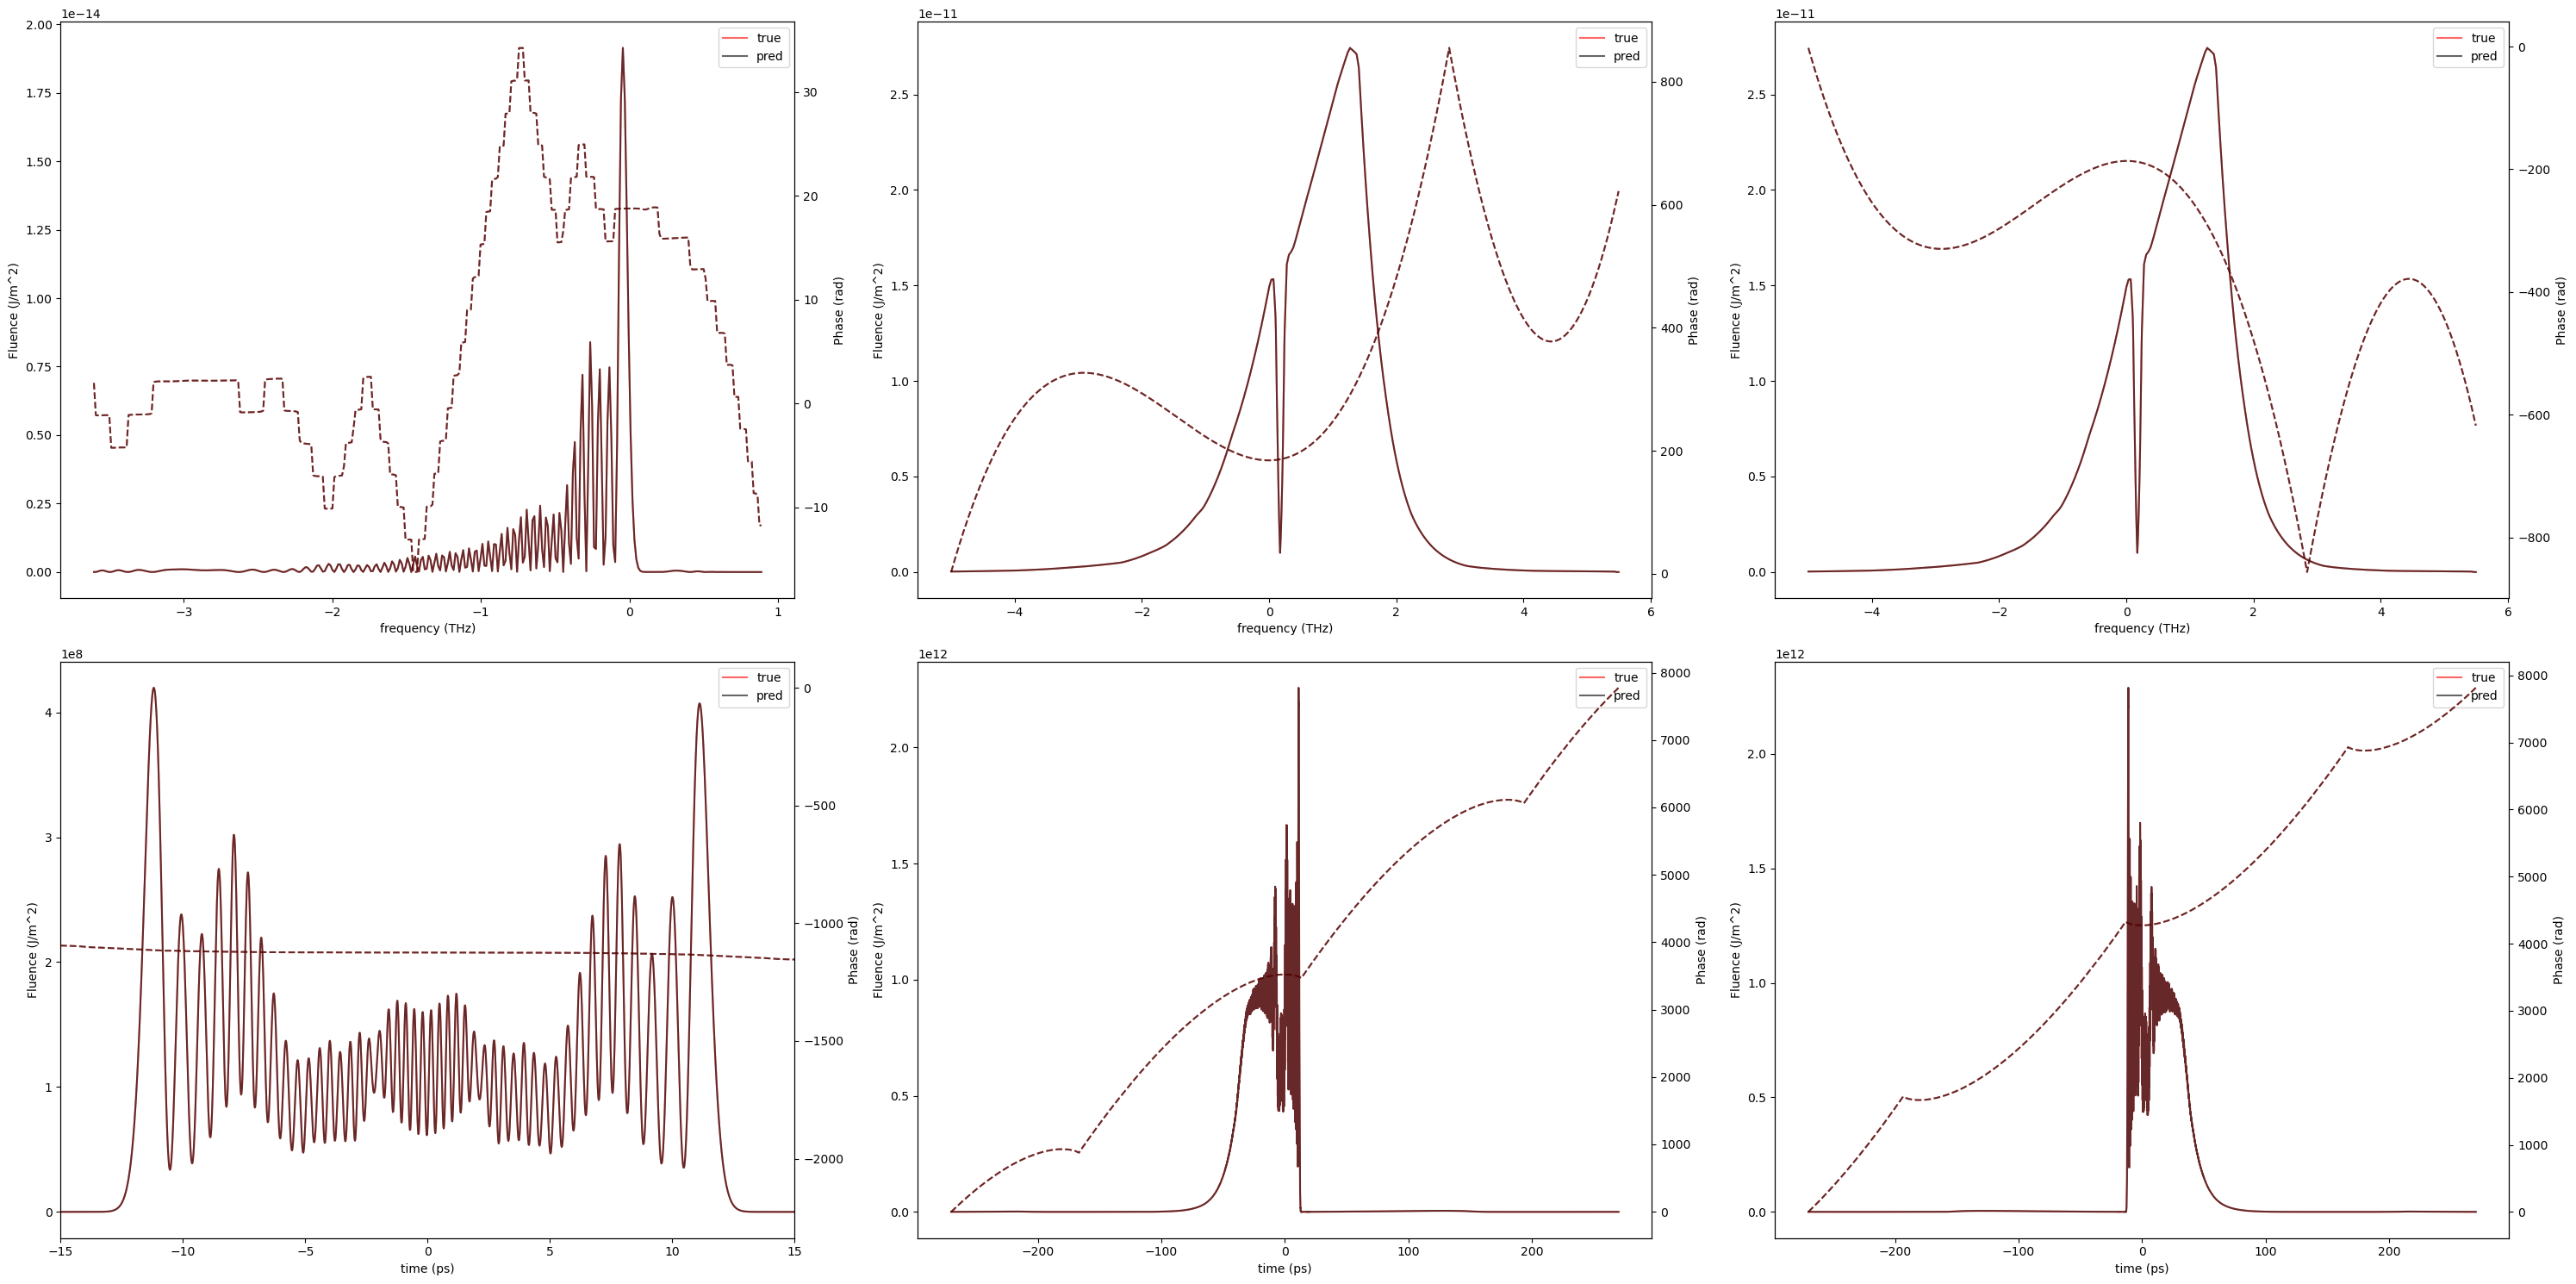

<Figure size 640x480 with 0 Axes>

In [14]:
do_analysis(".", data_dir, "blah", file_idx, sample_idx, ".", crystal_length, y_pred_trans_item=label)